# NOAA ASOS Data Fetching & Analysis

**Fetch and analyze ASOS weather data from IEM API**

Functions are in separate files:
- `asos_functions.py` - Data fetching & processing
- `asos_plotting.py` - Plotting functions

**Author**: OpenMesh Project  
**Date**: 2025-11-11

## 1. Setup & Imports

In [3]:

import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Add project root to path for imports
# Notebook is in: src/noaa_asos/
# Project root is 2 levels up from this directory
current_dir = Path(os.getcwd())
# Try to find project root (where src/ directory is)
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
elif (current_dir.parent.parent / 'src').exists():
    project_root = current_dir.parent.parent
else:
    # Fallback: assume we're in src/noaa_asos/ and go up 2 levels
    project_root = current_dir.parent.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import our modules
# Files are in src/noaa_asos/ (not src/fetch_data/noaa_asos/)
from src.noaa_asos import asos_functions as asos, asos_plotting as plots

# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100

print("✓ Setup complete")

✓ Setup complete


## 2. Configuration

In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Date range: Oct 29, 2023 to now
START_DATE = datetime(2023, 10, 29)
END_DATE = datetime.now()  # Current date/time

# Data resolution: '5min' or 'hourly'
DATA_RESOLUTION = '5min'

# Stations to fetch (from asos.STATIONS)
STATION_IDS = ['KJFK', 'KLGA', 'KNYC']

# Output options
SAVE_CSV = True
SAVE_PLOTS = False
SHOW_PLOTS = True
OUTPUT_DIR = Path('../data/noaa_asos')

# ============================================================================

# Calculate period info
days = (END_DATE - START_DATE).days
expected_records = days * 288  # 288 records per day for 5-min data

print(f"Period: {START_DATE.date()} to {END_DATE.date()}")
print(f"Total days: {days:,}")
print(f"Expected records per station: ~{expected_records:,} (5-min resolution)")
print(f"Resolution: {DATA_RESOLUTION}")
print(f"Stations: {STATION_IDS}")
print(f"Save CSV: {SAVE_CSV}")
print(f"Save Plots: {SAVE_PLOTS}")

Period: 2023-10-29 to 2025-11-30
Total days: 763
Expected records per station: ~219,744 (5-min resolution)
Resolution: 5min
Stations: ['KJFK', 'KLGA', 'KNYC']
Save CSV: True
Save Plots: False


## 3. Fetch Data

In [5]:
# Fetch raw data from IEM API
raw_data = asos.fetch_all_stations(
    station_ids=STATION_IDS,
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=DATA_RESOLUTION
)

if len(raw_data) > 0:
    first_station = list(raw_data.keys())[0]
    print(f"Columns: {len(raw_data[first_station].columns)}")
    print(f"  {list(raw_data[first_station].columns)[:10]}...")


FETCHING DATA (5min)

Fetching KJFK (5-min)... ✓ 231,082 records, 33 columns
Fetching KLGA (5-min)... ✓ 234,996 records, 33 columns
Fetching KNYC (5-min)... ✓ 22,954 records, 33 columns

✓ Fetched 3/3 stations

Columns: 33
  ['station', 'valid', 'lon', 'lat', 'elevation', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt']...


## 4. Process Data

In [6]:
# Convert to standard format (metric units)
processed_data = asos.process_all_stations(raw_data)

Processing data...

KJFK - JFK Airport:
  Records: 231,082
  Precipitation: 31,593 valid, 14,734 with rain

KLGA - LaGuardia Airport:
  Records: 234,996
  Precipitation: 32,165 valid, 15,058 with rain

KNYC - Central Park:
  Records: 22,954
  Precipitation: 22,953 valid, 4,904 with rain

✓ Processing complete



## 5. Precipitation Analysis

### 5.1 Precipitation Rate (Regular Time Series)

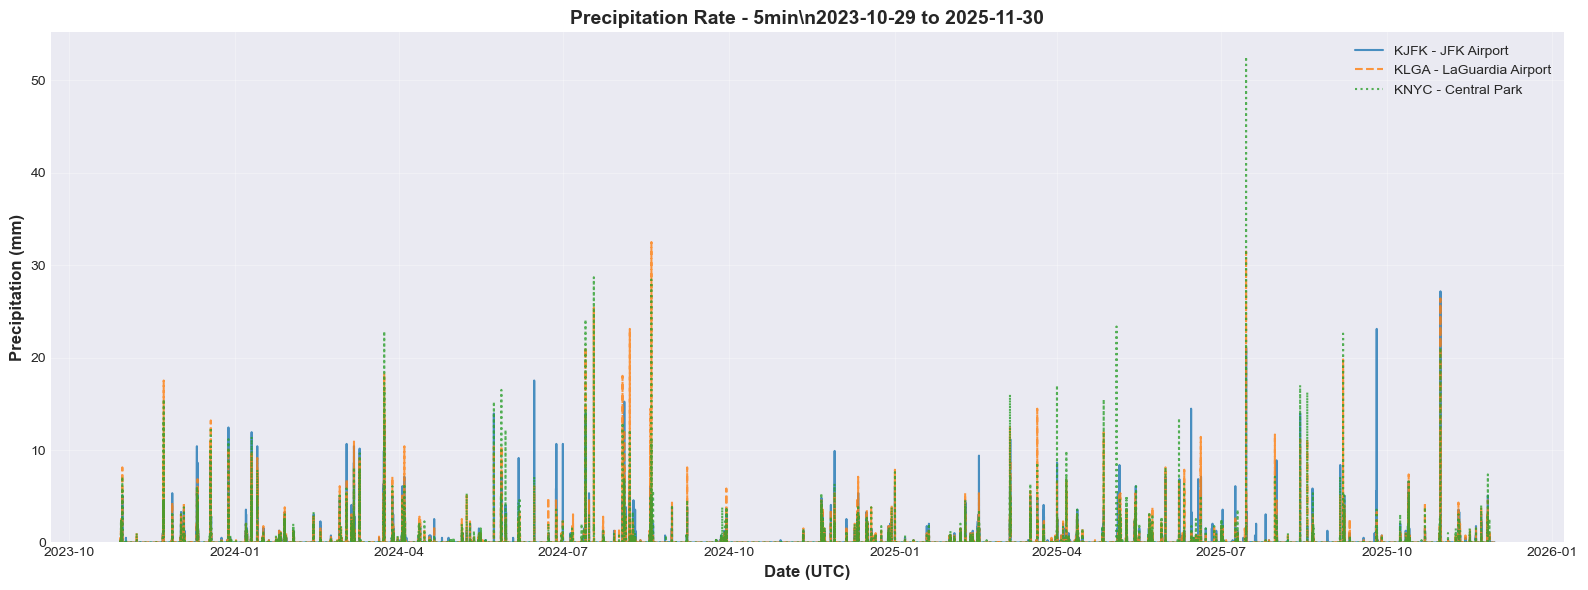

In [7]:
# Plot precipitation rate
plots.plot_precipitation_timeseries(
    processed_data=processed_data,
    stations_config=asos.STATIONS,
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=DATA_RESOLUTION,
    output_path=OUTPUT_DIR / 'precipitation_rate.png' if SAVE_PLOTS else None,
    show=SHOW_PLOTS
)

### 5.2 Accumulated Precipitation

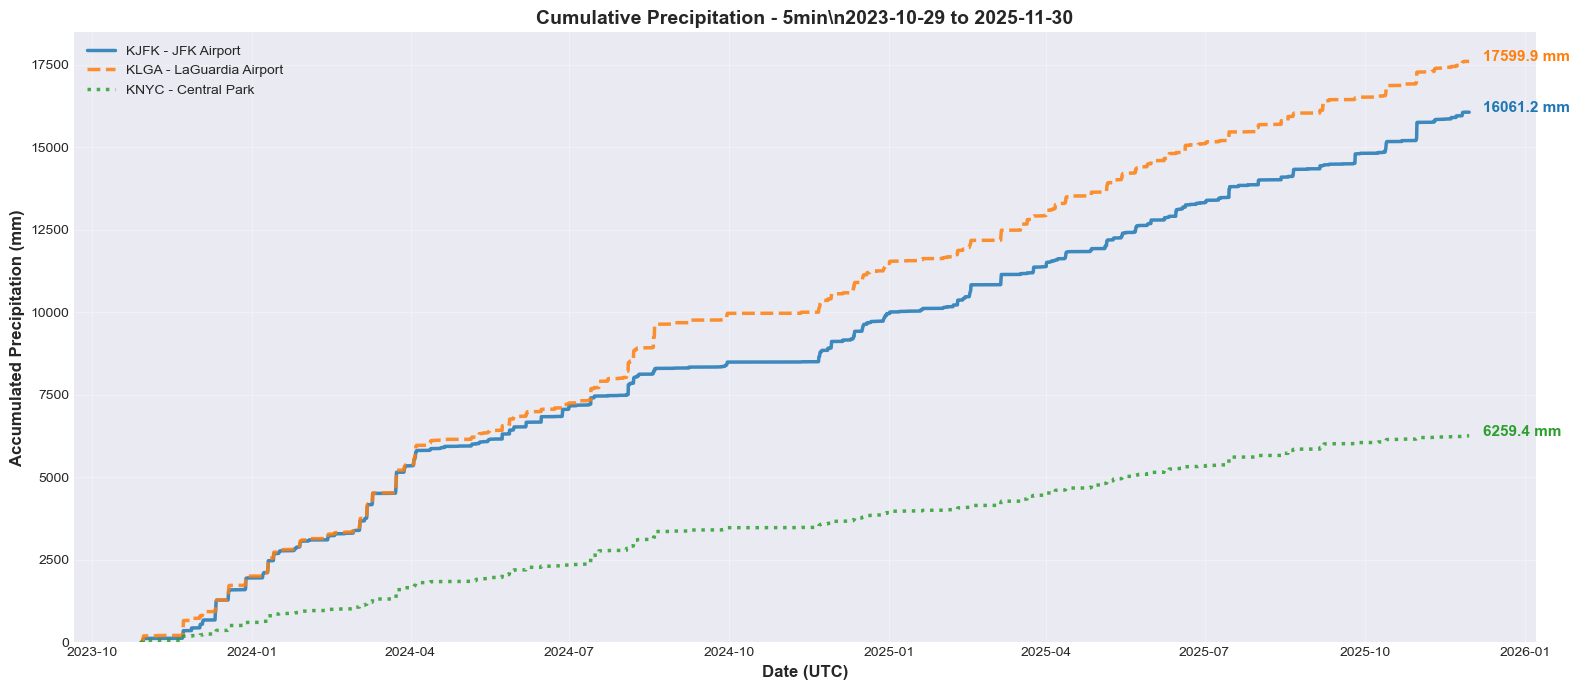

In [8]:
# Compute accumulated rainfall
accumulated_data = asos.compute_accumulated_for_all_stations(processed_data)

# Plot accumulated
plots.plot_accumulated_rainfall(
    accumulated_data=accumulated_data,
    stations_config=asos.STATIONS,
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=DATA_RESOLUTION,
    output_path=OUTPUT_DIR / 'accumulated_precipitation.png' if SAVE_PLOTS else None,
    show=SHOW_PLOTS
)

## 5.3. Save Data (Optional)

In [9]:
if SAVE_CSV:
    asos.save_processed_data(
        processed_data=processed_data,
        output_dir=OUTPUT_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        resolution=DATA_RESOLUTION
    )
else:
    print("ℹ CSV saving disabled (SAVE_CSV=False)")


Saving data...
  ✓ KJFK_20231029_20251130_5min.csv
  ✓ KLGA_20231029_20251130_5min.csv
  ✓ KNYC_20231029_20251130_5min.csv
  ✓ ALL_STATIONS_20231029_20251130_5min.csv

✓ Saved to: ../../data/noaa_asos



## 6. Other Variables

### 6.1 Temperature

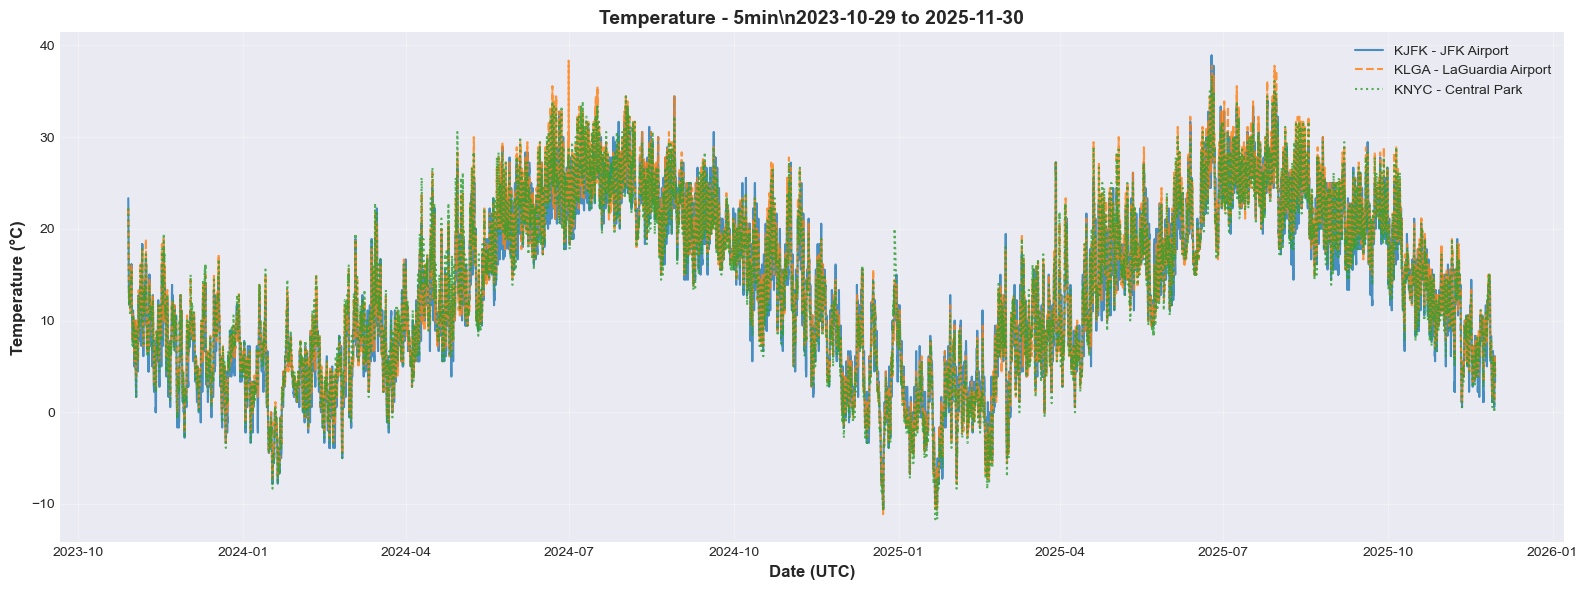

In [10]:
plots.plot_variable(
    processed_data=processed_data,
    stations_config=asos.STATIONS,
    variable='temp_c',
    ylabel='Temperature (°C)',
    title='Temperature',
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=DATA_RESOLUTION,
    output_path=OUTPUT_DIR / 'temperature.png' if SAVE_PLOTS else None,
    show=SHOW_PLOTS
)

### 6.2 Wind Speed

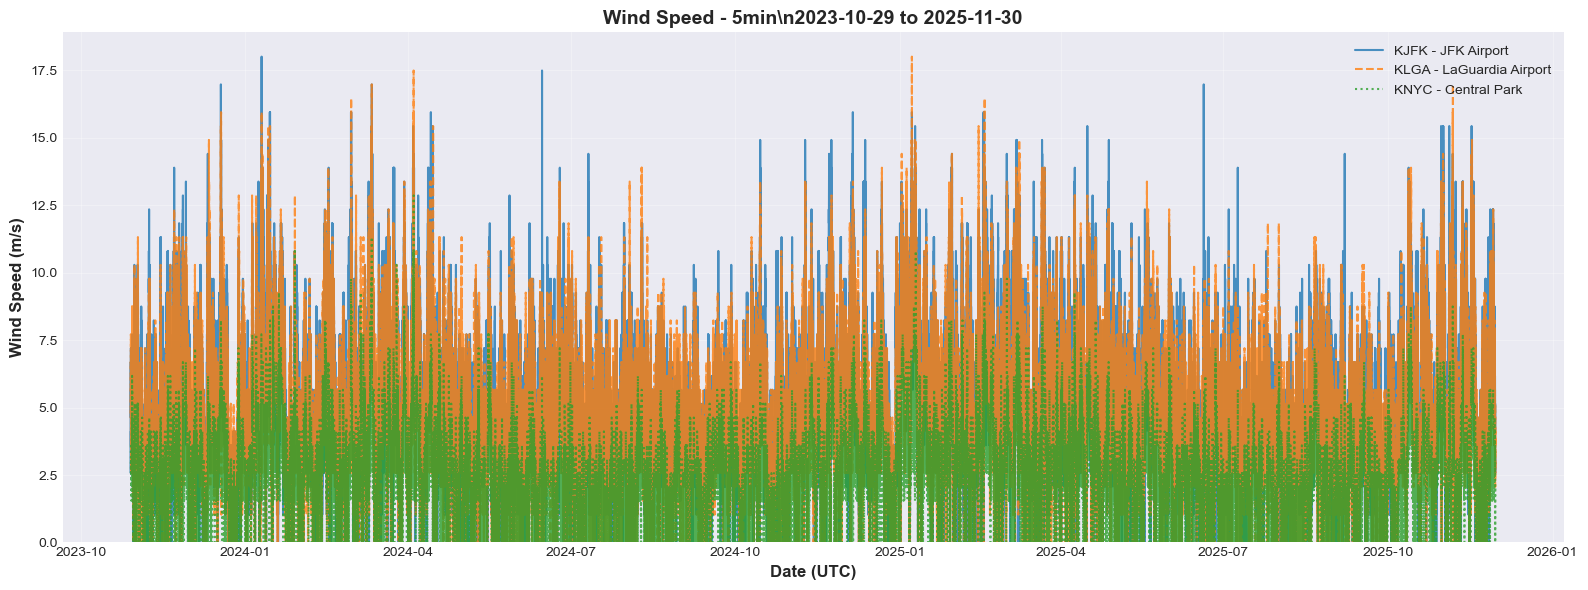

In [11]:
plots.plot_variable(
    processed_data=processed_data,
    stations_config=asos.STATIONS,
    variable='wind_speed_ms',
    ylabel='Wind Speed (m/s)',
    title='Wind Speed',
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=DATA_RESOLUTION,
    ylim_bottom=0,
    output_path=OUTPUT_DIR / 'wind_speed.png' if SAVE_PLOTS else None,
    show=SHOW_PLOTS
)

### 6.3 Pressure

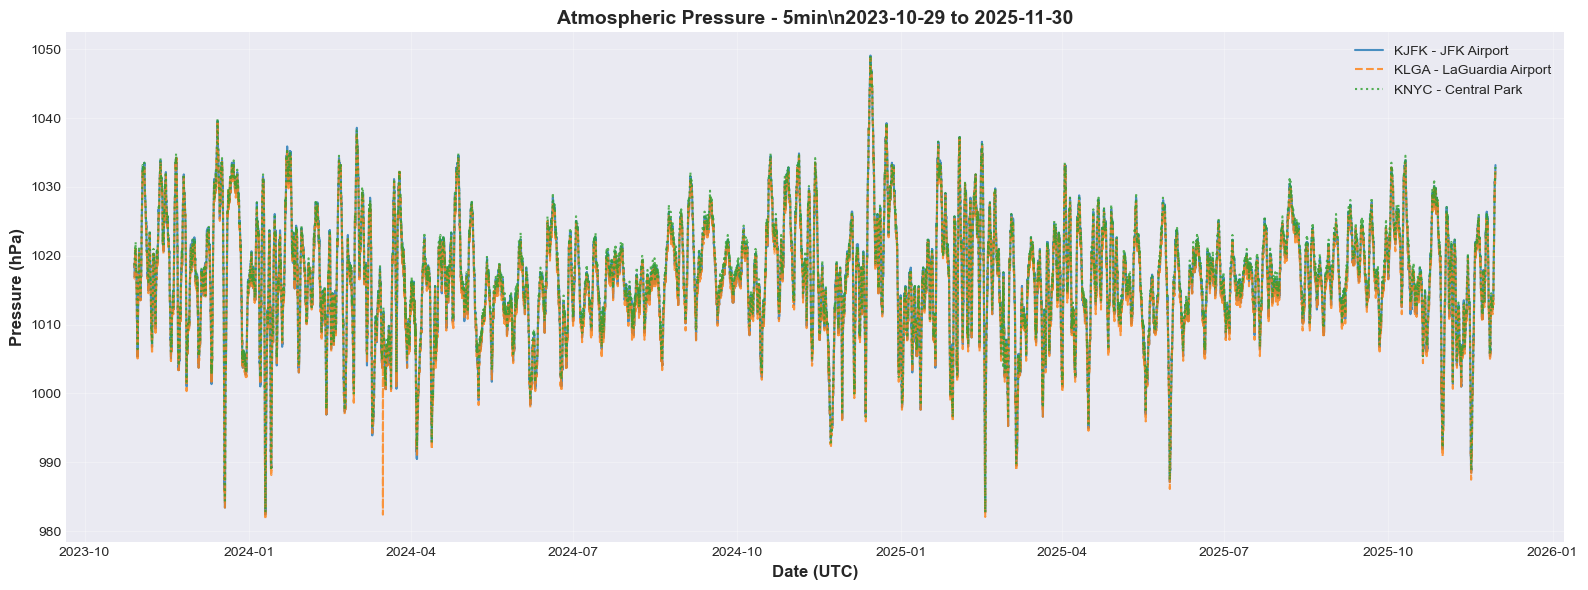

In [12]:
plots.plot_variable(
    processed_data=processed_data,
    stations_config=asos.STATIONS,
    variable='pressure_hpa',
    ylabel='Pressure (hPa)',
    title='Atmospheric Pressure',
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=DATA_RESOLUTION,
    output_path=OUTPUT_DIR / 'pressure.png' if SAVE_PLOTS else None,
    show=SHOW_PLOTS
)

## 8. Summary

In [13]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\nPeriod: {START_DATE.date()} to {END_DATE.date()}")
print(f"Resolution: {DATA_RESOLUTION}")
print(f"Stations: {len(processed_data)}")

print(f"\nPrecipitation Totals:")
for sid, df_accum in accumulated_data.items():
    total = df_accum['accumulated_mm'].iloc[-1]
    print(f"  {sid}: {total:.2f} mm")

print("\n" + "="*60)
print("✓ COMPLETE")
print("="*60)


SUMMARY

Period: 2023-10-29 to 2025-11-30
Resolution: 5min
Stations: 3

Precipitation Totals:
  KJFK: 16061.18 mm
  KLGA: 17599.86 mm
  KNYC: 6259.45 mm

✓ COMPLETE
